In [68]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation
import pandas as pd
from PIL import Image
import os
import shutil
from os.path import exists

import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

In [69]:
# Load the JSON data into a python dictionary
train_data = pd.read_json("train_data.json")

# Clean out the games that have no reviews
train_df = train_data.dropna(subset=["sentiment"])

# explode the dataset
train_df_expanded=train_df.explode("screenshots", ignore_index=True)


In [70]:
train_df_expanded

,appid,release,title,price,sentiment,reviews,percentage,tags,screenshots
0,2460480,2023-07-19,KILL CRAB,0,Very Positive,77.0,81.0,"[3D, Action, Action-Adventure, Adventure, Atmo...",2460480_ss_7d0cc1ba5160475a863d3cab18ae20c5319...
1,2460480,2023-07-19,KILL CRAB,0,Very Positive,77.0,81.0,"[3D, Action, Action-Adventure, Adventure, Atmo...",2460480_ss_ed40cec9267023b99fb3bf571a5c74556bb...
2,2460480,2023-07-19,KILL CRAB,0,Very Positive,77.0,81.0,"[3D, Action, Action-Adventure, Adventure, Atmo...",2460480_ss_ef88923d635e37c1a63ff2658f11a0ed489...
3,2460480,2023-07-19,KILL CRAB,0,Very Positive,77.0,81.0,"[3D, Action, Action-Adventure, Adventure, Atmo...",2460480_ss_f46c745c81786d4a8aa18187f2d942aff7a...
4,2460480,2023-07-19,KILL CRAB,0,Very Positive,77.0,81.0,"[3D, Action, Action-Adventure, Adventure, Atmo...",2460480_ss_f8008bc1bc867afb00beb2e8844d6386e32...
...,...,...,...,...,...,...,...,...,...
41786,2684300,2024-01-04,Just skill shooter 2,2140,Mostly Positive,17.0,70.0,"[Action, Action RPG, Arcade, FPS, First-Person...",2684300_ss_46ae97a9290948442fcb2418af5c161f856...
41787,2684300,2024-01-04,Just skill shooter 2,2140,Mostly Positive,17.0,70.0,"[Action, Action RPG, Arcade, FPS, First-Person...",2684300_ss_9031aae2fe1d233dbcc1269a2486fd86d87...
41788,2684300,2024-01-04,Just skill shooter 2,2140,Mostly Positive,17.0,70.0,"[Action, Action RPG, Arcade, FPS, First-Person...",2684300_ss_a182b3e3e54a88360f3d0ec05efd8d64a28...
41789,2684300,2024-01-04,Just skill shooter 2,2140,Mostly Positive,17.0,70.0,"[Action, Action RPG, Arcade, FPS, First-Person...",2684300_ss_b61bdccd5592ed797378e1a50985c6eb45c...


In [71]:
# Exploration and minor cleaning
print(train_data.columns)

print(train_data["sentiment"].value_counts())

dupe = train_data["appid"].value_counts()
if 2 in dupe.values:
    print("There is at least one value with a count of 2.")
else:
    print("No value has a count of 2.")

Index(['appid', 'release', 'title', 'price', 'sentiment', 'reviews',
       'percentage', 'tags', 'screenshots'],
      dtype='object')
sentiment
Positive                   1650
Very Positive              1148
Mixed                       736
Mostly Positive             664
Overwhelmingly Positive     109
Mostly Negative              89
Negative                      8
Very Negative                 1
Name: count, dtype: int64
No value has a count of 2.


In [72]:
# After this part it gets memory intensive, I have 16GB and it doesn't work so I used the external python script to make the images 256 256

In [73]:
# Initialize the transformation funciton
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     
     ])

In [74]:
""" # Makes a PIL image and transforms
train_df_expanded["images"] = None
for i in range(len(train_df_expanded["screenshots"])//2):
    screenshot_filename = train_df_expanded["screenshots"][i]
    image_path = f"C:/Users/Beste/Desktop/AAB/images/{screenshot_filename}"
    if exists(image_path):
        with Image.open(image_path) as image:
            image = image.convert('RGB')
            transformed_image = transform(image)
            train_df_expanded.at[i, "images"] = transformed_image

# Clean out the games that have no image
train_df_expanded = train_df_expanded.dropna(subset=["images"]) """

' # Makes a PIL image and transforms\ntrain_df_expanded["images"] = None\nfor i in range(len(train_df_expanded["screenshots"])//2):\n    screenshot_filename = train_df_expanded["screenshots"][i]\n    image_path = f"C:/Users/Beste/Desktop/AAB/images/{screenshot_filename}"\n    if exists(image_path):\n        with Image.open(image_path) as image:\n            image = image.convert(\'RGB\')\n            transformed_image = transform(image)\n            train_df_expanded.at[i, "images"] = transformed_image\n\n# Clean out the games that have no image\ntrain_df_expanded = train_df_expanded.dropna(subset=["images"]) '

In [75]:
""" # Create different files
def categorize_files(dataframe, source_folder, destination_folder):
    # Create destination folders if they don't exist
    categories = dataframe['sentiment'].unique()
    for category in categories:
        category_folder = os.path.join(destination_folder, category)
        if not os.path.exists(category_folder):
            os.makedirs(category_folder)

    # Iterate through rows in the DataFrame
    for index, row in dataframe.iterrows():
        filename = row['screenshots']
        source_file = os.path.join(source_folder, filename)
        if os.path.isfile(source_file):
            category = row['sentiment']
            destination_folder_category = os.path.join(destination_folder, category)
            shutil.copy(source_file, destination_folder_category)

if __name__ == "__main__":

    # Path to the big folder containing files to categorize
    source_folder = "C:/Users/Beste/Desktop/AAB/images"

    # Path to the folder where categorized files will be placed
    destination_folder = "C:/Users/Beste/Desktop/AAB/train"

    categorize_files(train_df_expanded, source_folder, destination_folder)
    print("Files categorized successfully!") """

' # Create different files\ndef categorize_files(dataframe, source_folder, destination_folder):\n    # Create destination folders if they don\'t exist\n    categories = dataframe[\'sentiment\'].unique()\n    for category in categories:\n        category_folder = os.path.join(destination_folder, category)\n        if not os.path.exists(category_folder):\n            os.makedirs(category_folder)\n\n    # Iterate through rows in the DataFrame\n    for index, row in dataframe.iterrows():\n        filename = row[\'screenshots\']\n        source_file = os.path.join(source_folder, filename)\n        if os.path.isfile(source_file):\n            category = row[\'sentiment\']\n            destination_folder_category = os.path.join(destination_folder, category)\n            shutil.copy(source_file, destination_folder_category)\n\nif __name__ == "__main__":\n\n    # Path to the big folder containing files to categorize\n    source_folder = "C:/Users/Beste/Desktop/AAB/images"\n\n    # Path to the f

In [76]:
# training dataset
train_dataset = datasets.ImageFolder(
    root='train',
    transform=transform
)

In [77]:
# training data loaders
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True
)

# Define classes
classes = ('Overwhelmingly Positive', 'Very Positive', 'Positive', 'Mostly Positive',
           'Mixed', 'Mostly Negative', 'Negative', 'Very Negative')

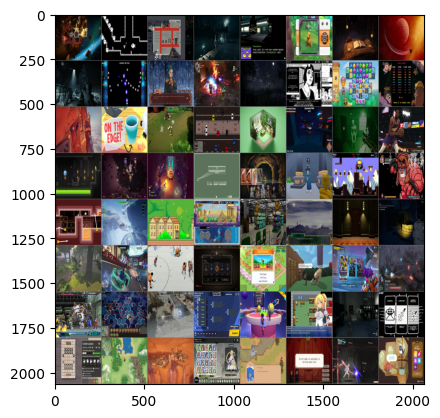

Positive Mostly Negative Very Negative Positive Very Negative Mostly Negative Very Negative Very Negative Overwhelmingly Positive Positive Mostly Negative Overwhelmingly Positive Overwhelmingly Positive Very Negative Very Negative Mostly Negative Mixed Very Negative Mostly Negative Mostly Negative Positive Very Negative Overwhelmingly Positive Very Positive Mostly Negative Very Negative Very Negative Mostly Negative Mostly Negative Positive Mostly Negative Very Negative Mostly Negative Mostly Negative Mostly Negative Mostly Negative Mostly Negative Very Negative Overwhelmingly Positive Positive Overwhelmingly Positive Overwhelmingly Positive Very Negative Mostly Negative Mostly Negative Very Negative Very Negative Positive Very Negative Mostly Negative Positive Overwhelmingly Positive Overwhelmingly Positive Positive Mostly Negative Very Negative Mostly Negative Mostly Negative Very Negative Positive Very Negative Positive Overwhelmingly Positive Positive


In [80]:
# Define a function to display images
def imshow(img):
    ''' function to show image '''
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()  # convert to numpy objects
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Iterate over batches of data using a for loop
for images, labels in train_loader:
    # Call function on your images here
    imshow(torchvision.utils.make_grid(images))
    # Print the class of each image in the batch
    batch_size = images.size(0)
    print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))
    break  # Exit the loop after displaying the first batch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 5)
        
        self.fc1 = nn.Linear(256, 50)
        
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.fc1(x)
        return x

In [ ]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import time

from tqdm.auto import tqdm

from model import CNNModel
from datasets import train_loader, valid_loader
from utils import save_model, save_plots

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-e', '--epochs', type=int, default=20,
    help='number of epochs to train our network for')
args = vars(parser.parse_args())

In [ ]:
# learning_parameters 
lr = 1e-3
epochs = args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")
model = CNNModel().to(device)
print(model)

# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc
# validation
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)
    
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')